In [0]:
#import dependencies
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [0]:
# read diamonds.csv file into spark dataframe
quotes_by_char_df = spark.read.csv("dbfs:/FileStore/tables/quotes_by_char.csv", header=True, inferSchema=True)
quotes_by_char_df.show(5)

+---+-----------+--------------------+
_c0| character| all_quotes|
+---+-----------+--------------------+
 0| & C|Well met, Master ...|
 1| A Lord| Sir, it was I. |
 2|A Patrician|This man has marr...|
 3| A Player|So please your lo...|
 4| AARON|Now climbeth Tamo...|
+---+-----------+--------------------+
only showing top 5 rows

In [0]:
quotes_by_char_df.count()

Out[71]: 966

In [0]:
from pyspark.sql.functions import lower, col

#drop the unnamed column
quotes_by_char_df = quotes_by_char_df.drop('_c0')

#convert character names to lower case
quotes_by_char_df = quotes_by_char_df.select(lower(col('character')).alias('character'),col('all_quotes'))

quotes_by_char_df.show(5)

+-----------+--------------------+
 character| all_quotes|
+-----------+--------------------+
 & c|Well met, Master ...|
 a lord| Sir, it was I. |
a patrician|This man has marr...|
 a player|So please your lo...|
 aaron|Now climbeth Tamo...|
+-----------+--------------------+
only showing top 5 rows

In [0]:
display(quotes_by_char_df.toPandas().head())

character all_quotes & c Well met, Master Ford. a lord Sir, it was I. a patrician This man has marr'd his fortune. You do the nobler. Ay, and burn too. a player So please your lordship to accept our duty. I think 'twas Soto that your honour means. Fear not, my lord: we can contain ourselves, Were he the veriest antic in the world. aaron Now climbeth Tamora Olympus' top, Safe out of fortune's shot; and sits aloft, Secure of thunder's crack or lightning flash; Advanced above pale envy's threatening reach. As when the golden sun salutes the morn, And, having gilt the ocean with his beams, Gallops the zodiac in his glistering coach, And overlooks the highest-peering hills; So Tamora: Upon her wit doth earthly honour wait, And virtue stoops and trembles at her frown. Then, Aaron, arm thy heart, and fit thy thoughts, To mount aloft with thy imperial mistress, And mount her pitch, whom thou in triumph long Hast prisoner held, fetter'd in amorous chains And faster bound to Aaron's charming eyes Than is Prometheus tied to Caucasus. Away with slavish weeds and servile thoughts! I will be bright, and shine in pearl and gold, To wait upon this new-made empress. To wait, said I? to wanton with this queen, This goddess, this Semiramis, this nymph, This siren, that will charm Rome's Saturnine, And see his shipwreck and his commonweal's. Holloa! what storm is this? [Aside] Clubs, clubs! these lovers will not keep the peace. [Coming forward] Why, how now, lords! So near the emperor's palace dare you draw, And maintain such a quarrel openly? Full well I wot the ground of all this grudge: I would not for a million of gold The cause were known to them it most concerns; Nor would your noble mother for much more Be so dishonour'd in the court of Rome. For shame, put up. Away, I say! Now, by the gods that warlike Goths adore, This petty brabble will undo us all. Why, lords, and think you not how dangerous It is to jet upon a prince's right? What, is Lavinia then become so loose, Or Bassianus so degenerate, That for her love such quarrels may be broach'd Without controlment, justice, or revenge? Young lords, beware! and should the empress know This discord's ground, the music would not please. Why, are ye mad? or know ye not, in Rome How furious and impatient they be, And cannot brook competitors in love? I tell you, lords, you do but plot your deaths By this device. To achieve her! how? [Aside] Ay, and as good as Saturninus may. Why, then, it seems, some certain snatch or so Would serve your turns. Would you had hit it too! Then should not we be tired with this ado. Why, hark ye, hark ye! and are you such fools To square for this? would it offend you, then That both should speed? For shame, be friends, and join for that you jar: 'Tis policy and stratagem must do That you affect; and so must you resolve, That what you cannot as you would achieve, You must perforce accomplish as you may. Take this of me: Lucrece was not more chaste Than this Lavinia, Bassianus' love. A speedier course than lingering languishment Must we pursue, and I have found the path. My lords, a solemn hunting is in hand; There will the lovely Roman ladies troop: The forest walks are wide and spacious; And many unfrequented plots there are Fitted by kind for rape and villany: Single you thither then this dainty doe, And strike her home by force, if not by words: This way, or not at all, stand you in hope. Come, come, our empress, with her sacred wit To villany and vengeance consecrate, Will we acquaint with all that we intend; And she shall file our engines with advice, That will not suffer you to square yourselves, But to your wishes' height advance you both. The emperor's court is like the house of Fame, The palace full of tongues, of eyes, and ears: The woods are ruthless, dreadful, deaf, and dull; There speak, and strike, brave boys, and take your turns; There serve your lusts, shadow'd from heaven's eye, And revel in Lavinia's treasury. He that had wit would think that I had 

In [0]:
from pyspark.ml.feature import RegexTokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml import Pipeline

#regex tokenizer
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("all_quotes")\
  .setOutputCol("words")

#fetch stopwords from a website
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

#stop words remover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

#count vectorizer
cv = CountVectorizer(minTF=4., minDF=10.).setInputCol("filtered").setOutputCol("tf")

#idf
idf = IDF().setInputCol('tf').setOutputCol('tfidf')

pipe_1 = Pipeline(stages=[tokenizer, sw_filter,cv, idf]).fit(quotes_by_char_df)
pipe_1_df = pipe_1.transform(quotes_by_char_df)
pipe_1_df.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
 character| all_quotes| words| filtered| tf| tfidf|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
 & c|Well met, Master ...|[well, met, maste...| [met, master, ford]| (4375,[],[])| (4375,[],[])|
 a lord| Sir, it was I. | [sir, it, was, i]| [sir]| (4375,[],[])| (4375,[],[])|
a patrician|This man has marr...|[this, man, has, ...|[man, marr, d, fo...| (4375,[],[])| (4375,[],[])|
 a player|So please your lo...|[so, please, your...|[lordship, accept...| (4375,[],[])| (4375,[],[])|
 aaron|Now climbeth Tamo...|[now, climbeth, t...|[climbeth, tamora...|(4375,[0,1,2,3,4,...|(4375,[0,1,2,3,4,...|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
# standardize features
from pyspark.ml.feature import StandardScaler
center = StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')

In [0]:
from pyspark.ml.feature import PCA
# pca scores
pca = PCA(k=500, inputCol='centered_tfidf', outputCol='scores')

In [0]:
pipe_pca_1 = Pipeline(stages=[pipe_1, center, pca]).fit(quotes_by_char_df)
chars_pca_df = pipe_pca_1.transform(quotes_by_char_df)
chars_pca_df.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 character| all_quotes| words| filtered| tf| tfidf| centered_tfidf| scores|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 & c|Well met, Master ...|[well, met, maste...| [met, master, ford]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
 a lord| Sir, it was I. | [sir, it, was, i]| [sir]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
a patrician|This man has marr...|[this, man, has, ...|[man, marr, d, fo...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
 a player|So please your lo...|[so, please, your...|[lordship, accept...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
 aaron|Now climbeth Tamo...|[now, climbeth, t...|[climbeth, tamora...|(4375,[0,1,2,3,4,...|(4375,[0,1,2,3,4,...|[16.2317260554718...|[-41.321359528766...|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
pipe_pca_1.stages[-1].explainedVariance

Out[78]: DenseVector([0.2449, 0.0553, 0.0384, 0.0278, 0.025, 0.0238, 0.0185, 0.0173, 0.0164, 0.0157, 0.0154, 0.0137, 0.0131, 0.0122, 0.0116, 0.0103, 0.01, 0.0098, 0.0093, 0.0092, 0.0089, 0.0084, 0.0079, 0.0077, 0.0074, 0.0072, 0.007, 0.0068, 0.0066, 0.0062, 0.006, 0.0057, 0.0056, 0.0055, 0.0053, 0.0051, 0.0051, 0.0049, 0.0048, 0.0047, 0.0046, 0.0045, 0.0044, 0.0044, 0.0043, 0.0043, 0.0041, 0.004, 0.0039, 0.0039, 0.0038, 0.0037, 0.0036, 0.0035, 0.0034, 0.0033, 0.0033, 0.0032, 0.0032, 0.0031, 0.0029, 0.0029, 0.0029, 0.0028, 0.0027, 0.0027, 0.0027, 0.0026, 0.0026, 0.0025, 0.0024, 0.0023, 0.0023, 0.0023, 0.0023, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.002, 0.002, 0.002, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0014, 0.0014, 0.0014, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [0]:
#sum of the explained variance vector near 100%
sum(pipe_pca_1.stages[-1].explainedVariance)

Out[79]: 0.9999999999999941

In [0]:
#number of rows and cols in the TF-IDF data in chars_pca_df here
print("TF-IDF number of rows and columns : " + str(pipe_1_df.count()) + " X " + str(len(pipe_1.stages[-2].vocabulary)))

TF-IDF number of rows and columns : 966 X 4375

In [0]:
#display(chars_pca_df.toPandas().head())

Out[82]:

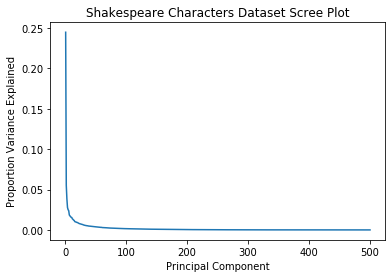

Text(0, 0.5, 'Proportion Variance Explained')

In [0]:
#plot scree plot
plt.figure()
explained_var = pipe_pca_1.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Shakespeare Characters Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Out[83]:

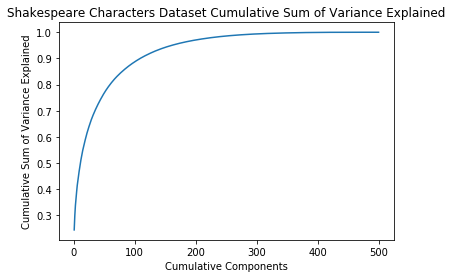

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

In [0]:
#cumulative variance plot
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Shakespeare Characters Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

##### We would choose 300 principal components on the basis of the information we see in the plot. We can see that cumulative sum of variance reaches 1.0 when components are 300.

We create a function named get_nearest_chars that takes 2 arguments: char and num_nearest_chars. The char arg is a string which defines the character for which we are interested in finding similar characters. The num_nearest_chars arg is an integer that defines the total number of nearest characters which we want included in the return list. The get_nearest_chars function performs all of its internal operations in spark and returns a python list containing a string corresponding to each of the nearest characters defined by num_nearest_chars. It computes the list of characters which are closest to the char arg using L2 Euclidian distance.

In [0]:
#pca model for k=2
pipe_2 = pipe_1
pca_2 = PCA(k=2, inputCol='centered_tfidf', outputCol='scores')

pipe_pca_2 = Pipeline(stages=[pipe_2, center, pca_2]).fit(quotes_by_char_df)
chars_pca_df_2 = pipe_pca_2.transform(quotes_by_char_df)
chars_pca_df_2.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 character| all_quotes| words| filtered| tf| tfidf| centered_tfidf| scores|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 & c|Well met, Master ...|[well, met, maste...| [met, master, ford]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|
 a lord| Sir, it was I. | [sir, it, was, i]| [sir]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|
a patrician|This man has marr...|[this, man, has, ...|[man, marr, d, fo...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|
 a player|So please your lo...|[so, please, your...|[lordship, accept...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|
 aaron|Now climbeth Tamo...|[now, climbeth, t...|[climbeth, tamora...|(4375,[0,1,2,3,4,...|(4375,[0,1,2,3,4,...|[16.2317260554718...|[-41.321359528766...|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
from pyspark.sql.functions import udf,asc
from pyspark.sql import types
import numpy as np

#function to find euclidian distance
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

l2_dist_udf = udf(l2_dist, types.FloatType())

spark.sql("SET spark.sql.crossJoin.enabled=TRUE").show()

+--------------------+-----+
 key|value|
+--------------------+-----+
spark.sql.crossJo...| TRUE|
+--------------------+-----+

In [0]:
#function to get nearest characters
def get_nearest_chars(char,num_nearest_chars):
  try:
    nearest_chars_pd = (pipe_pca_2.transform(quotes_by_char_df).\
                     where('character == "'+char+'"').\
                     select(col("scores").alias('char_scores')).\
                     join(pipe_pca_2.transform(quotes_by_char_df)).\
                     withColumn('dist', l2_dist_udf('scores', 'char_scores')).\
                     select("character", "dist").\
                     orderBy(asc("dist")).\
                     limit(num_nearest_chars+1).\
                     toPandas())
    nearest_chars_list = nearest_chars_pd['character'].tolist()[1:]
    return nearest_chars_list
  except:
    return None

In [0]:
print(get_nearest_chars('romeo', 5))
print(get_nearest_chars('juliet', 5))

['juliet', 'king henry iv', 'pericles', 'duke vincentio', 'prospero']
['romeo', 'duke vincentio', 'cleopatra', 'king henry iv', 'pericles']

In [0]:
pipe_pca_2.stages

Out[88]: [PipelineModel_f5ff0d558be7,
 StandardScalerModel: uid=StandardScaler_47cd6d3ba14e, numFeatures=4375, withMean=true, withStd=false,
 PCAModel: uid=PCA_a59178d05b92, k=2]

In [0]:
char_names = np.array(quotes_by_char_df.select('character').rdd.map(lambda x: x['character']).collect())
X = np.array(pipe_pca_2.transform(quotes_by_char_df).select('scores').rdd.map(lambda x: x['scores']).collect())
print("X.shape:", X.shape)

X.shape: (966, 2)

In [0]:
#filter data
idx1 = ((X[:, 0] < (-100)) & ( X[:, 0] > (-300)))
X = X[idx1]
char_names = char_names[idx1]

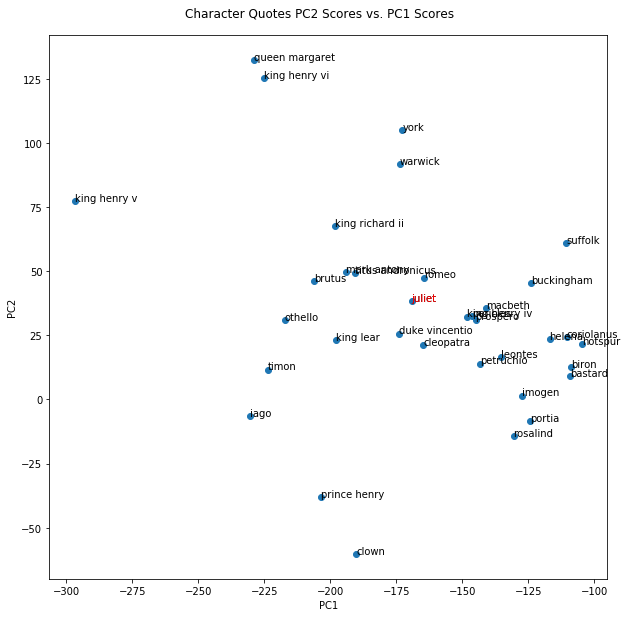

In [0]:
# plot the data
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(X[:,0], X[:,1])
fig.suptitle("Character Quotes PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i, txt in enumerate(char_names):
    ax.annotate(txt, (X[i,0], X[i,1]))

#highlight juliet
ax.annotate('juliet', (X[np.where(char_names=="juliet")][0][0], X[np.where(char_names=="juliet")][0][1]), color='red')
    
display(plt.show())

Inference analysis on the 10 most and 10 least important words in the data set as defined by the absolute value of the PC1 loading vector coefficients.

In [0]:
pipe_pca_2.stages

Out[92]: [PipelineModel_f5ff0d558be7,
 StandardScalerModel: uid=StandardScaler_47cd6d3ba14e, numFeatures=4375, withMean=true, withStd=false,
 PCAModel: uid=PCA_a59178d05b92, k=2]

In [0]:
pipe_2.stages

Out[93]: [RegexTokenizer_58513c4aece6,
 StopWordsRemover_58c591e8586b,
 CountVectorizerModel: uid=CountVectorizer_675c81dfb384, vocabularySize=4375,
 IDFModel: uid=IDF_ccb18b450210, numDocs=966, numFeatures=4375]

In [0]:
pca_model = pipe_pca_2.stages[-1]
#get first principal component
pc1 = pca_model.pc.toArray()[:, 0].tolist()

In [0]:
vocabulary = pipe_2.stages[2].vocabulary

In [0]:
pc_loadings = pd.DataFrame([vocabulary, pc1]).T.rename(columns={0: 'word', 1: 'loading'})
print(pc_loadings.shape)

(4375, 2)

In [0]:
# biggest and smallest loadings of pc1
most_imp_df = pc_loadings.sort_values('loading').head(10)
least_imp_df = pc_loadings.sort_values('loading').tail(10)

In [0]:
# grading cell - do not modify
display(most_imp_df)
display(least_imp_df)

word,loading
thou,-0.27720573666016973
s,-0.2248469942439496
thy,-0.20000646328966615
d,-0.19150239839534694
thee,-0.18213476880887802
shall,-0.16125503641162925
o,-0.15479254848357726
ll,-0.14545185074503605
good,-0.14085271238489155
let,-0.13717763445893724


word,loading
thorough,2.1469561477637024E-4
horn,2.2623838860677992E-4
spring,2.477255639614073E-4
aunt,2.489087034652801E-4
humours,2.5690208281762774E-4
varro,2.65265018648848E-4
rumour,3.0670517122837864E-4
grandsire,3.98253925544448E-4
pyramus,4.242005907793912E-4
wall,7.385672192758289E-4


Thy, thou, thee, shall are most important in Shakespeare's character quotes while horn, spring, aunt, humours, rumour, wall are least important. These are just nouns that can be used in any story and have nothing to do with Shakespeare's particular stype of writing.

# K-Means Clustering

In [0]:
from pyspark.ml import clustering
from pyspark.ml.feature import Normalizer
from pyspark.ml.evaluation import ClusteringEvaluator

pca3 = PCA(k=300, inputCol='centered_tfidf', outputCol='scores')

#normalizer and evaluator
norm = Normalizer(inputCol="scores", outputCol="norm_tfidf",p=2.0)
evaluator = ClusteringEvaluator().setFeaturesCol("norm_tfidf"). \
                                  setPredictionCol("kmeans_feat"). \
                                  setMetricName("silhouette")

pipe_pca_3 = Pipeline(stages=[pipe_1, center, pca3]).fit(quotes_by_char_df)
chars_pca_df3 = pipe_pca_3.transform(quotes_by_char_df)
chars_pca_df3.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 character| all_quotes| words| filtered| tf| tfidf| centered_tfidf| scores|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 & c|Well met, Master ...|[well, met, maste...| [met, master, ford]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
 a lord| Sir, it was I. | [sir, it, was, i]| [sir]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
a patrician|This man has marr...|[this, man, has, ...|[man, marr, d, fo...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
 a player|So please your lo...|[so, please, your...|[lordship, accept...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558268...|
 aaron|Now climbeth Tamo...|[now, climbeth, t...|[climbeth, tamora...|(4375,[0,1,2,3,4,...|(4375,[0,1,2,3,4,...|[16.2317260554718...|[-41.321359528766...|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
silhouette_scores = []
for k in range(2,7):  
  highest_score = 0.0
  for i in range(3):
    kmeans = clustering.KMeans(k=k, featuresCol='norm_tfidf', predictionCol='kmeans_feat', seed=1)
    pipe_k = Pipeline(stages=[norm, kmeans]).fit(chars_pca_df3)
    kmeans_df = pipe_k.transform(chars_pca_df3)
    silhouette_score = evaluator.evaluate(kmeans_df)
    if silhouette_score > highest_score :
      highest_score = silhouette_score
  silhouette_scores.append(highest_score)
  print(silhouette_scores)

[0.5664503824812727]
[0.5664503824812727, 0.4859035420045799]
[0.5664503824812727, 0.4859035420045799, 0.44135234657465977]
[0.5664503824812727, 0.4859035420045799, 0.44135234657465977, 0.4433581461488801]
[0.5664503824812727, 0.4859035420045799, 0.44135234657465977, 0.4433581461488801, 0.4138776885777868]

In [0]:
highest_silhoutte_score = max(silhouette_scores)
best_k_index = silhouette_scores.index(highest_silhoutte_score)
print("The highest silhouette score is ---->  " + str(highest_silhoutte_score) + " ----> for K=" + str(2+best_k_index) )

The highest silhouette score is ----> 0.5664503824812727 ----> for K=2

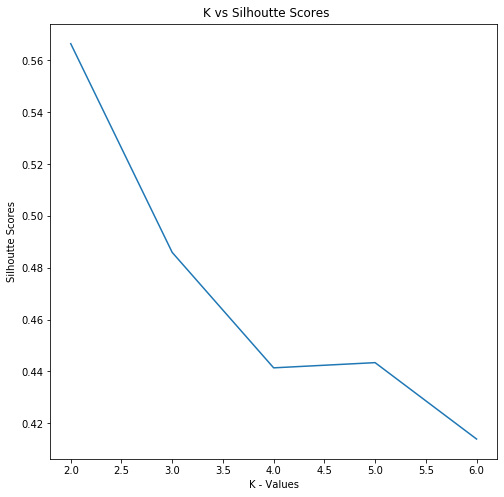

In [0]:
#plot k vs silhouette scree plot
fig, ax = plt.subplots(1,1, figsize =(8,8))
ax.plot(range(2,7),silhouette_scores)
ax.set_xlabel('K - Values')
ax.set_ylabel('Silhoutte Scores')
fig.suptitle("K vs Silhoutte Scores", y=.91)
plt.show()

In [0]:
kmeans = clustering.KMeans(k=2, featuresCol='norm_tfidf', predictionCol='kmeans_feat')
pipe_pca_4 = Pipeline(stages=[norm, kmeans]).fit(chars_pca_df_2)
chars_pca_df_4 = pipe_pca_4.transform(chars_pca_df_2)
chars_pca_df_4.show()

+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+
 character| all_quotes| words| filtered| tf| tfidf| centered_tfidf| scores| norm_tfidf|kmeans_feat|
+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+
 & c|Well met, Master ...|[well, met, maste...| [met, master, ford]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 a lord| Sir, it was I. | [sir, it, was, i]| [sir]| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 a patrician|This man has marr...|[this, man, has, ...|[man, marr, d, fo...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 a player|So please your lo...|[so, please, your...|[lordship, accept...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 aaron|Now climbeth Tamo...|[now, climbeth, t...|[climbeth, tamora...|(4375,[0,1,2,3,4,...|(4375,[0,1,2,3,4,...|[16.2317260554718...|[-41.321359528766...|[-0.9565687543366...| 1|
 abergavenny|I cannot tell Wha...|[i, cannot, tell,...|[tell, heaven, ha...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 abhorson|Do you call, sir?...|[do, you, call, s...|[sir, bawd, sir, ...|(4375,[9,973],[6....|(4375,[9,973],[9....|[-6.0773486741566...|[18.9633118022126...|[0.98486731380260...| 0|
 abraham|Do you bite your ...|[do, you, bite, y...|[bite, thumb, sir...| (4375,[9],[4.0])|(4375,[9],[6.4668...|[-6.0773486741566...|[19.5178709150808...|[0.99337392040869...| 0|
 achilles|Why, how now, Aja...|[why, how, now, a...|[ajax, wherefore,...|(4375,[0,1,2,3,4,...|(4375,[0,1,2,3,4,...|[8.50935403367735...|[-11.599043411431...|[-0.9999859438166...| 1|
 adam|Yonder comes my m...|[yonder, comes, m...|[yonder, comes, m...|(4375,[6,40,63],[...|(4375,[6,40,63],[...|[-6.0773486741566...|[15.1636499371430...|[0.78471748016810...| 0|
 adrian|Though this islan...|[though, this, is...|[island, desert, ...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 adriana|Neither my husban...|[neither, my, hus...|[husband, slave, ...|(4375,[0,1,2,3,5,...|(4375,[0,1,2,3,5,...|[2.50306468339277...|[-33.268181777961...|[-0.9788943188479...| 1|
adriano de armado|Boy, what sign is...|[boy, what, sign,...|[boy, sign, man, ...|(4375,[0,1,3,5,6,...|(4375,[0,1,3,5,6,...|[5.93523002641253...|[-19.999479179944...|[-0.9804783235948...| 1|
 aegeon|Proceed, Solinus,...|[proceed, solinus...|[proceed, solinus...|(4375,[0,1,2,6,17...|(4375,[0,1,2,6,17...|[-2.6451833311368...|[5.81723575498033...|[0.89945989535540...| 0|
 aemelia|Be quiet, people....|[be, quiet, peopl...|[quiet, people, w...|(4375,[1,2,3,14,4...|(4375,[1,2,3,14,4...|[-6.0773486741566...|[13.3613599430945...|[0.99752275468583...| 0|
 aemilius|Arm, arm, my lord...|[arm, arm, my, lo...|[arm, arm, lord, ...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 aeneas|How now, Prince T...|[how, now, prince...|[prince, troilus,...|(4375,[0,2,4,7,8,...|(4375,[0,2,4,7,8,...|[-0.0710593238720...|[5.26551388045433...|[0.70277229102614...| 0|
 aedile|Peace, peace! He'...|[peace, peace, he...|[peace, peace, s,...| (4375,[],[])| (4375,[],[])|[-6.0773486741566...|[20.1209991558267...|[0.99681128639206...| 0|
 agamemnon|Princes, What gri...|[princes, what, g...|[princes, grief, ...|(4375,[0,1,2,4,8,...|(4375,[0,1,2,4,8,...|[0.78698201188289...|[4.29812167022293...|[0.99858466572979...| 0|
 agrippa|Give me leave, Ca...|[give, me, leave,...|[leave, caesar, t...|(4375,[2,7,33,99,...|(4375,[2,7,33,99,...|[-6.0773486741566...|[15.8924721454904...|[0.99895166446816...| 0|
+-----

In [0]:
char_names2 = np.array(chars_pca_df_4.select('character').rdd.map(lambda x: x['character']).collect())
k_group = np.array(chars_pca_df_4.select('kmeans_feat').rdd.map(lambda x: x['kmeans_feat']).collect())
X2 = np.array(chars_pca_df_4.select('scores').rdd.map(lambda x: x['scores']).collect())
print("X.shape:", X2.shape)

X.shape: (966, 2)

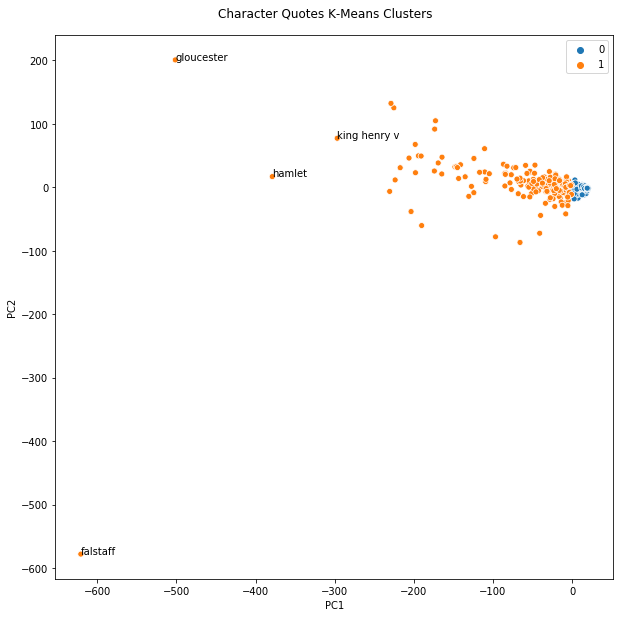

In [0]:
# plot the data
import seaborn as sns
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

sns.scatterplot(X2[:,0], X2[:,1], hue=k_group)

fig.suptitle("Character Quotes K-Means Clusters", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

idx2 = X2[:, 0] < (-250)
X2_temp = X2[idx2]
char_names2_temp = char_names2[idx2]
for i, txt in enumerate(char_names2_temp):
    ax.annotate(txt, (X2_temp[i,0], X2_temp[i,1]))

plt.show()

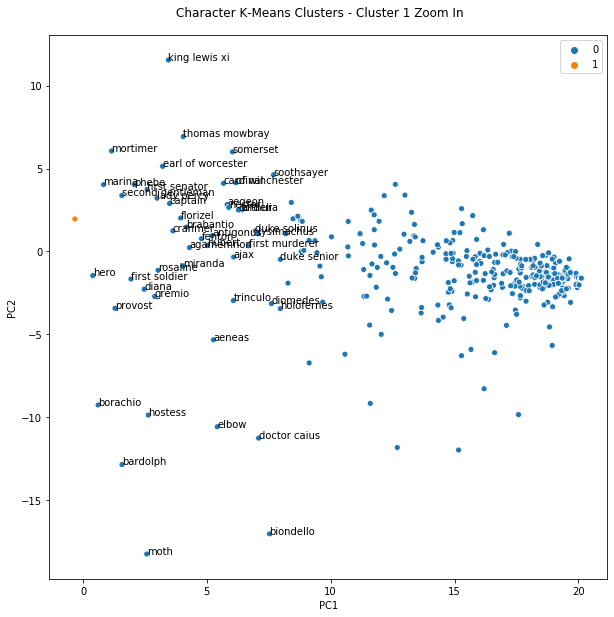

In [0]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

idx3 = X2[:, 0] > -0.4
X2_temp = X2[idx3]
char_names2_temp = char_names2[idx3]
k_group_temp = k_group[idx3]

sns.scatterplot(X2_temp[:,0], X2_temp[:,1], hue=k_group_temp)

fig.suptitle("Character K-Means Clusters - Cluster 1 Zoom In", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

idx4 = ((X2[:, 0] < 8) & (X2[:, 0] > 0))
X2_temp1 = X2[idx4]
char_names2_temp1 = char_names2[idx4]
for i, txt in enumerate(char_names2_temp1):
    ax.annotate(txt, (X2_temp1[i,0], X2_temp1[i,1]))

plt.show()

Falstaff, Gloucester, King Henry V, Hamlet are the outliers and stand out from rest of the cluster-0. King Lewis XI, Moth, Biondello, Hero, Borachio, Marina, Bardolph, Mortimer, Thomas Mowbray are the outliers and stand out from rest of the cluster-1.